# Analyzing running routes within each cluster

## Importing the libraries

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We will need Play and Player Play datasets along with the clusters dataset that we've got from our clustering model.

In [4]:
plays = pd.read_csv('data/plays.csv')

In [2]:
player_play = pd.read_csv('data/player_play.csv')

In [3]:
movers_clusters = pd.read_csv('data/movers_clusters.csv')

## Some data preprocessing

We will need to leave only several columns for this analysis, so let's clean the data little bit.

In [6]:
players = player_play
players_merged = pd.merge(players, plays, on=['gameId', 'playId'])
players_merged_filtered = players_merged[players_merged['teamAbbr'] == players_merged['possessionTeam']] # Leaving only players from the possession team

In [22]:
# List of columns to keep
columns_to_keep = [
    "gameId", "playId", "nflId", "teamAbbr", "routeRan"
]

# Keep only these columns from the dataset
players_filtered = players_merged_filtered[columns_to_keep]

In [23]:
players_filtered.head()

,gameId,playId,nflId,teamAbbr,routeRan
0,2022090800,56,35472,BUF,NaN
1,2022090800,56,42392,BUF,NaN
2,2022090800,56,42489,BUF,IN
3,2022090800,56,44875,BUF,NaN
4,2022090800,56,44985,BUF,OUT


We removed all the columns except for the column representing the route ran by player. Now, we want to leave only players that made pre-snap motion, and also add clusters.

In [59]:
players_with_clusters = pd.merge(players_filtered, movers_clusters, on=['gameId', 'playId', 'nflId'])

Since we assigned clusters only to players that were in motion at the moment of the snap, columns that have no cluster represent players that didn't have pre-snap movements. So we can drop them. We will also drop all the outliers that we detected during clusters (cluster values of -1).

In [60]:
players_with_clusters = players_with_clusters.dropna(subset=['cluster'])
players_with_clusters = players_with_clusters.loc[players_with_clusters['cluster'] != -1]

Now, let's look at the routeRan column.

In [61]:
players_with_clusters.head()

,gameId,playId,nflId,teamAbbr,routeRan,cluster
0,2022090800,80,47857,BUF,NaN,1
2,2022090800,212,47879,BUF,IN,0
3,2022090800,236,52536,BUF,CORNER,3
4,2022090800,299,44881,LA,NaN,6
5,2022090800,343,44881,LA,NaN,6


Let's convert all NaN values to 'Not Ran'.

In [62]:
players_with_clusters['routeRan'] = players_with_clusters['routeRan'].fillna('NOT RAN')

## Calculating the probabilities of running routes

Now, let's get to our main goal – calculate the probability of route ran within each cluster. By probability in this case we mean the proportion of the number of times specific route was ran to the total number of entries within each cluster.

In [63]:
route_counts = players_with_clusters.groupby(['cluster', 'routeRan']).size().reset_index(name='count')
total_counts = players_with_clusters.groupby('cluster').size().reset_index(name='total')
route_probs = pd.merge(route_counts, total_counts, on='cluster')
route_probs['probability'] = route_probs['count'] / route_probs['total']

In [64]:
prob_table = route_probs.pivot(index='cluster', columns='routeRan', values='probability').fillna(0)

print("Probability of each routeRan within each cluster:\n")
print(prob_table)

Probability of each routeRan within each cluster:

routeRan     ANGLE    CORNER     CROSS      FLAT        GO     HITCH  \
cluster                                                                
0         0.000000  0.014815  0.195062  0.056790  0.069136  0.017284   
1         0.003597  0.017986  0.100719  0.075540  0.075540  0.057554   
2         0.000000  0.016393  0.049180  0.068852  0.144262  0.078689   
3         0.000000  0.011111  0.226667  0.042222  0.048889  0.017778   
4         0.010274  0.034247  0.092466  0.061644  0.061644  0.054795   
5         0.000000  0.000000  0.218085  0.021277  0.007979  0.007979   
6         0.000000  0.008929  0.151786  0.071429  0.118304  0.042411   
7         0.003257  0.026059  0.078176  0.087948  0.159609  0.078176   
8         0.000000  0.023055  0.083573  0.054755  0.126801  0.060519   
9         0.045576  0.000000  0.002681  0.364611  0.010724  0.008043   
10        0.000000  0.006263  0.202505  0.037578  0.054280  0.010438   
11        0.0

And let's create a visual representation with the help of heatmap.

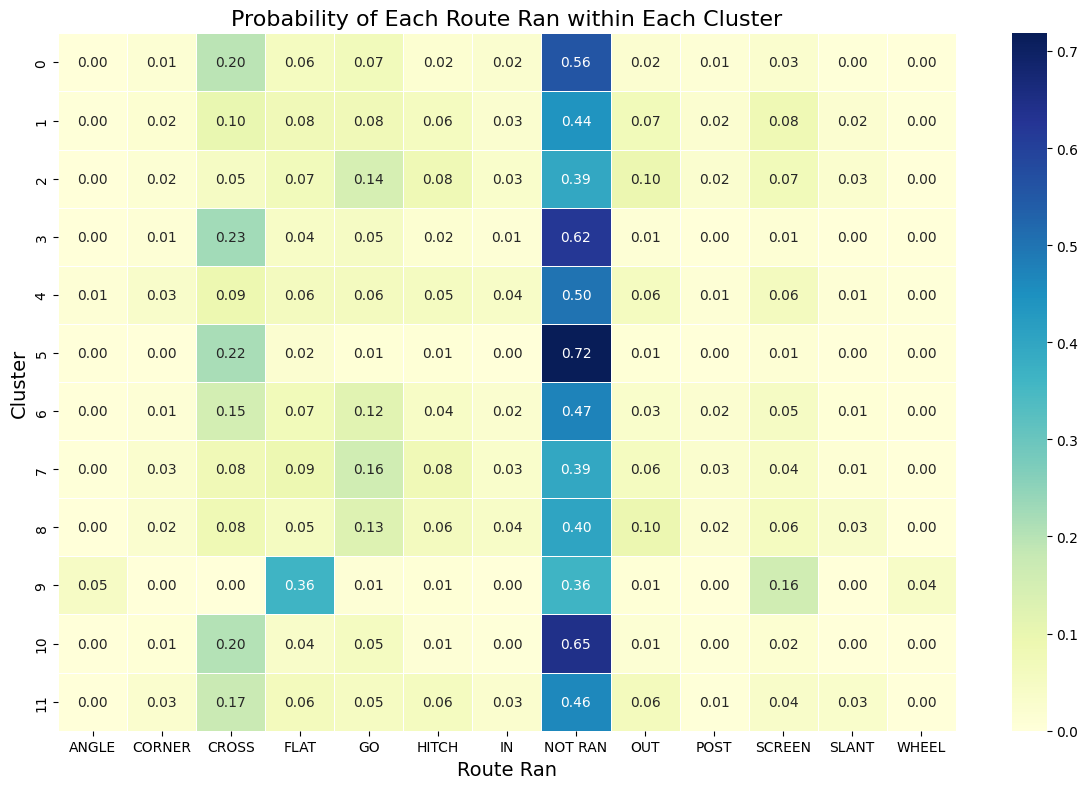

In [65]:
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(prob_table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)

# Customize the plot
plt.title('Probability of Each Route Ran within Each Cluster', fontsize=16)
plt.xlabel('Route Ran', fontsize=14)
plt.ylabel('Cluster', fontsize=14)

# Show the plot
plt.tight_layout()
plt.savefig('figures/route_ran_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [53]:
total_route_counts = players_with_clusters['routeRan'].value_counts().sort_index()

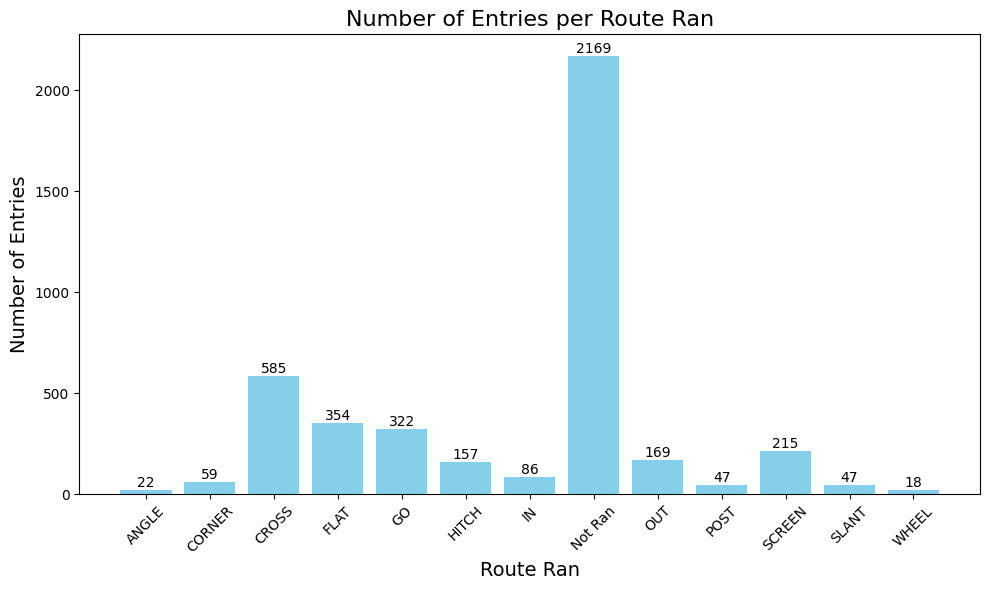

In [57]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(total_route_counts.index, total_route_counts.values, color='skyblue')

# Add titles and labels
plt.title('Number of Entries per Route Ran', fontsize=16)
plt.xlabel('Route Ran', fontsize=14)
plt.ylabel('Number of Entries', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add count labels on top of each bar
for index, value in enumerate(total_route_counts.values):
    plt.text(index, value + 0.05, str(value), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.savefig('figures/route_ran_histogram.png', dpi=300, bbox_inches='tight')
plt.show()